In [1]:
###############################################################
#
# ADIABATIC_FLAME - A freely-propagating, premixed flat flame 
#             
###############################################################

import cantera  as ct
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
"""
Compute numerical derivatives on a non-uniform (but strictly increasing) grid,
using quadratic Lagrangian interpolation to generate the difference matrix.
"""
import numpy as np
from scipy.sparse import csr_matrix

#--------------------------------------------------------------------------

def differenceMatrix(x):
    """Generates the difference matrix for a non-uniform (but strictly 
    increasing) abscissa.  We use a two-sided finite difference for the 
    interior points, with one-sided differences for the boundary.  Interior 
    point coefficients are calculated using the derivatives of the 2nd-order 
    Lagrange polynomials for the approximation.

    ARGS:
        x: array.
            strictly increasing 1D grid.  Must contain at least 2 elements.
    """
    n = len(x)
    h = x[1:]-x[:n-1]   # length n-1 array of grid spacings
    a0 = -(2*h[0]+h[1])/(h[0]*(h[0]+h[1]))
    ak = -h[1:]/(h[:n-2]*(h[:n-2]+h[1:]))
    an = h[-1]/(h[-2]*(h[-1]+h[-2]))
    b0 = (h[0]+h[1])/(h[0]*h[1]) 
    bk = (h[1:] - h[:n-2])/(h[:n-2]*h[1:])
    bn = -(h[-1]+h[-2])/(h[-1]*h[-2])
    c0 = -h[0]/(h[1]*(h[0]+h[1]))
    ck = h[:n-2]/(h[1:]*(h[:n-2]+h[1:]))
    cn = (2*h[-1]+h[-2])/(h[-1]*(h[-2]+h[-1]))
    val  = np.hstack((a0,ak,an,b0,bk,bn,c0,ck,cn))
    row = np.tile(np.arange(n),3)
    dex = np.hstack((0,np.arange(n-2),n-3))
    col = np.hstack((dex,dex+1,dex+2))
    D = csr_matrix((val,(row,col)),shape=(n,n))
    return D

#--------------------------------------------------------------------------

def strictlyIncreasing(x):
    """Checks that an input array is strictly increasing.

    ARGS:
        x: array-like.
            Numerical array.
    """
    isIncreasing = True
    for x1,x2 in zip(x,x[1:]):
        isIncreasing = isIncreasing and x1<x2
    return isIncreasing

def deriv(*args):
    """Calculates numerical derivative for strictly increasing, non-uniform grid,
    using quadrating Lagrangian interpolation to generate the difference matrix.

    ARGS:
        called with one or two 1-D arrays; 2 arrays must be of equal length.
        When called with one array, deriv(y), computes the 1st derivative of 
        that array using a uniform, integer-spaced grid, similar to numpy.gradient.
        When called with two arrays, assumes the form deriv(x,y), calculates the 
        derivative of y on the non-uniform grid x.
    """
    if len(args) == 1:
        y = args[0]
        x = np.arange(0,len(y),dtype=np.float64)
    else:
        x = args[0]
        y = args[1]
        if len(x) != len(y):
            raise ValueError("Input arrays must be of equal size.")
        if len(x) < 2:
            raise ValueError("Input array(s) must contain at least 2 elements")
        if not strictlyIncreasing(x):
            raise ValueError("Input grid must be strictly increasing")
    try:
        x = np.array(x,dtype=np.float64)
        y = np.array(y,dtype=np.float64)
    except:
        raise ValueError("Inputs could not be conditioned to float arrays.")
    if len(x.shape) > 1 or len(y.shape) > 1:
        raise ValueError("Inputs must be 1-D arrays")
    D = differenceMatrix(x)
    return D*y


In [3]:
def flameStructure(flame, gas, mixture, phi, Tu, pres, fuel):
    """ Calculates the structure of an 1-D freely propagating laminar flame """
    #
    #Set tolerance properties -------------------------------
    tol_ss    = [1.0e-7, 1.0e-12]   # [rtol atol] for steady-state problem
    tol_ts    = [1.0e-4, 1.0e-7]    # [rtol atol] for time stepping
    #
    loglevel= 0        # amount of diagnostic output (0 to 5)
    refine= True       # True to enable refinement
    #
    #
    m=gas.n_species
    #
    #gas.set_equivalence_ratio(phi, 'H2:0.99, H2O:0.01', 'O2:0.21, N2:0.79')
    gas.set_equivalence_ratio(phi, mixture, 'O2:0.21, N2:0.79')
    Yu = gas.Y
    #
    #Set gas state to that of the unburned gas -----------------
    gas.TP = Tu, pres
    gas.Y  = Yu
    print("In flame solver: pres=", pres)
    #
    #flame.set_fixed_temperature(650)
    #
    flame.flame.set_steady_tolerances(default=tol_ss)
    flame.flame.set_transient_tolerances(default=tol_ts)
    flame.inlet.X = gas.X
    flame.inlet.T = Tu
    SL_prev=0.0
    # 
    #  solution starts here
    #
    #----------------------------
    #   first flame -----
    #----------------------------
    #
    # No energy to start ------
    print("First solution...")
    flame.energy_enabled = False
    #
    # Refinement criteria ---------
    flame.set_refine_criteria(ratio = 7.0, slope = 1, curve = 1)
    #
    # Max number of times Jacobian will be used before reevaluation
    flame.set_max_jac_age(50, 50)
    #
    # Set time steps whenever Newton convergence fails
    flame.set_time_step(1.e-06, [25, 50, 100])    # [s]
    #
    #Calculation ----------------
    try: 
       flame.solve(loglevel, refine_grid=refine)
    except Exception:
        print("Failed at phi = ", phi)
    SL_new=flame.velocity[0]
    print("    SL = ", SL_new*100, " cm/s, % diff: ", abs(SL_new-SL_prev)/SL_new*100)
    SL_prev=SL_new
    #
    #----------------------------
    #
    print("First refinement...")
    #    enable energy equation 
    flame.energy_enabled = True
    #    refinement criteria when energy equation is enabled
    flame.set_refine_criteria(ratio = 5.0, slope = 0.5, curve = 0.5)
    #    calculate 
    try:
        flame.solve(loglevel, refine_grid=refine)
    except Exception:
        print("Failed at phi = ", phi)
    SL_new=flame.velocity[0]
    print("    SL = ", SL_new*100, " cm/s, % diff: ", abs(SL_new-SL_prev)/SL_new*100)
    SL_prev=SL_new
    #
    #----------------------------
    #
    print("Second refinement...")
    #
    flame.set_refine_criteria(ratio = 5.0, slope = 0.3, curve = 0.3)
    try: 
        flame.solve(loglevel, refine_grid=refine)
    except Exception:
        print("Failed at phi = ", phi)
    SL_new=flame.velocity[0]
    print("    SL = ", SL_new*100, " cm/s, % diff: ", abs(SL_new-SL_prev)/SL_new*100)
    SL_prev=SL_new
    #
    #----------------------------
    #
    print("Third refinement...")
    #
    flame.set_refine_criteria(ratio = 3.0, slope = 0.1, curve = 0.1)
    try: 
        flame.solve(loglevel, refine_grid=refine)
    except Exception:
        print("Failed at phi = ", phi)
    SL_new=flame.velocity[0]
    print("    SL = ", SL_new*100, " cm/s, % diff: ", abs(SL_new-SL_prev)/SL_new*100)
    SL_prev=SL_new
    #
    #----------------------------
    #
    print("Fourth refinement...")
    #
    flame.set_refine_criteria(ratio = 2.0, slope = 0.05, curve = 0.05, prune = 0.01)
    try:
        flame.solve(loglevel, refine_grid=refine)
    except Exception:
        print("Failed at phi = ", phi)
    #
    SL_new=flame.velocity[0]
    print("    SL = ", SL_new*100, " cm/s, % diff: ", abs(SL_new-SL_prev)/SL_new*100)
    SL_prev=SL_new
    #
    #----------------------------
    #
    print("Fifth refinement...")
    #
    flame.set_refine_criteria(ratio = 2.0, slope = 0.01, curve = 0.01)
    try: 
        flame.solve(loglevel, refine_grid=refine)
    except Exception:
        print("Failed at 5th refinement")
    #
    SL_new=flame.velocity[0]
    print("    SL = ", SL_new*100, " cm/s, % diff: ", abs(SL_new-SL_prev)/SL_new*100)
    SL_prev=SL_new
    #
    #----------------------------
    #
    print("Sixth refinement...")
    #
    tol_ss    = [1.0e-6, 1.0e-14]   # [rtol atol] for steady-state problem
    flame.flame.set_steady_tolerances(default=tol_ss)
    flame.set_refine_criteria(ratio = 2.0, slope = 0.008, curve = 0.009)
    try: 
        flame.solve(loglevel, refine_grid=refine)
    except Exception:
        print("Failed at 6th refinement")
    #
    SL_new=flame.velocity[0]
    print("    SL = ", SL_new*100, " cm/s, % diff: ", abs(SL_new-SL_prev)/SL_new*100)
    SL_prev=SL_new
    #
    #----------------------------
    #
    print("Seventh refinement...")
    #
    flame.set_refine_criteria(ratio = 2.0, slope = 0.005, curve = 0.005)
    try: 
        flame.solve(loglevel, refine_grid=refine)
    except Exception:
        print("Failed at 7th refinement")
    #
    SL_new=flame.velocity[0]
    print("    SL = ", SL_new*100, " cm/s, % diff: ", abs(SL_new-SL_prev)/SL_new*100)
    SL_prev=SL_new
    #
    #print("   atol_ss= ", flame.flame.steady_abstol() )
    #print("   rtol_ss= ", flame.flame.steady_reltol() )
    #
    return flame

In [4]:
def plotFlameStructure(flame):
    #Plot the velocity, temperature, selected species mole fractions
    z = flame.flame.grid
    T = flame.T
    u = flame.velocity
    #
    fig=figure(1)
    # 
    # create first subplot - adiabatic flame temperature --------
    a=fig.add_subplot(221)
    a.plot(100*z,T)
    a.set_xlim(min(100*z),max(100*z))
    #title(r'$T_{adiabatic}$ vs. Position')
    xlabel(r'x [cm]', fontsize=15)
    ylabel("Adiabatic Flame Temperature [K]")
    a.xaxis.set_major_locator(MaxNLocator(10))    #  controls the number of 
                                                  #  tick marks on the axis
    # create second subplot - velocity --------
    b=fig.add_subplot(222)
    b.plot(100*z,u)
    b.set_xlim(min(100*z),max(100*z))
    #title(r'Velocity vs. Position')
    xlabel(r'x [cm]', fontsize=15)
    ylabel("velocity [m/s]")
    b.xaxis.set_major_locator(MaxNLocator(10)) 
    # 
    # create third subplot - OH, HO2, H2O2 ---
    c=fig.add_subplot(223)
    pOH   = zeros(flame.flame.n_points,'d')
    pHO2  = zeros(flame.flame.n_points,'d')
    pH2O2 = zeros(flame.flame.n_points,'d')
    for n in range(flame.flame.n_points):
        flame.set_gas_state(n)
        pOH[n]  = gas.Y[gas.species_index('OH')]
        pHO2[n] = gas.Y[gas.species_index('HO2')]
        pH2O2[n]= gas.Y[gas.species_index('H2O2')]
    # 
    c.plot(100*z,  pOH,    'b', label='OH')
    c.plot(100*z,20*pHO2,  'r', label='20*HO2')
    c.plot(100*z,50*pH2O2, 'k', label='50*H2O2')
    c.set_xlim(min(100*z),max(100*z))
    c.legend(frameon=False)
    #title(r'OH vs. Position')
    xlabel(r'x [cm]', fontsize=15)
    ylabel("X$_{k}$")
    c.xaxis.set_major_locator(MaxNLocator(10)) 
    # 
    # create fourth subplot - CH4
    d=fig.add_subplot(224)
    h2 = np.zeros(flame.flame.n_points,'d')
    for n in range(flame.flame.n_points):
        flame.set_gas_state(n)
        h2[n]= gas.Y[gas.species_index(fuel)]
    # 
    d.plot(100*z, h2)
    d.set_xlim(min(100*z),max(100*z))
    #title(r'CH4 vs. Position')
    xlabel(r'x [cm]', fontsize=15)
    ylabel("X$_{H_2}$" )
    d.xaxis.set_major_locator(MaxNLocator(10))
    # 
    # Set title
    fig.text(0.5,0.95,r'Adiabatic H$_{2}$/air free flame',fontsize=22,horizontalalignment='center')
    # 
    subplots_adjust(left=0.08, right=0.96, wspace=0.25)
    flame.show_stats
    show()
    # 
    return

In [9]:
#Import gas phases with mixture transport model ----------

rxn_mech = 'Chemical mechanisms/BurkeH2.yaml'
#rxn_mech = 'chem_Burke2012.yaml'

gas = ct.Solution(rxn_mech)

ns = gas.n_species
nr = gas.n_reactions

print("Mechanism: {}".format(rxn_mech))
print("The mechanism has {} species and {} reactions".format(ns, nr))

# domain size
L = 0.06     # [m]

#  Uniform initial grid 
initial_grid = np.linspace(0.0, L, 51)     

#----------------------------------------
#  Compute flame structure
#----------------------------------------

fuel = 'H2'
mixture = 'H2:1.0, H2O:0.0, N2:0.0'

phi = 0.10
T0  = 298.0   # [K]

#pres_list = np.arange(1.0, 20.0, 1)
pres_list = [1.0]
pres      = np.zeros(len(pres_list))
SL        = np.zeros(len(pres_list))
deltaf    = np.zeros(len(pres_list))

# molecular weights
WT = gas.molecular_weights

i = 0
for pr in pres_list: 
    #General ------------------------------------------------
    pres[i] = pr
    PP = ct.one_atm * pr        # pressure [Pascal]
    Tu =  T0                    # unburned gas temperature
    gas.TP = Tu, PP
    print ("   ")
    print ("Unburned mixture: Tu = {} K p= {} atm phi={}".format(Tu, pres[i], phi))
    #
    flame = ct.FreeFlame(gas, initial_grid)
    flame.transport_model='mixture-averaged'
    #flame.transport_model='multicomponent'
    #flame.soret_enabled=True
    flameStruc = flameStructure(flame, gas, mixture, phi, Tu, PP, fuel)
    #
    #----------------------------------------
    #  Save results in a CSV file
    #----------------------------------------
    #
    #  Write velocity [m/s], vel. gradient [1/s], T [K], 
    #        density [kg/m3], and mass fractions to a CSV file
    #fname='Tu_'+str(Tu)+'K_p_'+str(Pa)+'atm_phi_'+str(phi[i])+mech+'.csv'
    #flame.write_csv(fname, species='Y', quiet=False)
    #
    #----------------------------------------
    #  Plot results
    #----------------------------------------
    #----------------------------------------
    #  Save results in a text file
    #----------------------------------------
    z = flame.grid
    T = flame.T
    npts = len(z)
    #
    #fname='Tu_'+str(Tu)+'K_p_'+str(Pa)+'atm_phi_'+str(phi[i])+'.dat'
    #f = open(fname, "w")
    #f.write('#X[cm]        T[K]\n')
    #for jp in range(npts):
    #    Ysp = [i[jp] for i in flame.Y]
    #    #strFormat = (3+len(Ysp))*'%.5e '
    #    print( z[jp]*100, flame.velocity[jp]*100, T[jp], Ysp )
    #    f.write( str(z[jp]*100) + '   ' + str(T[jp])+'\n' )
    ##
    #f.close()
    # 
    #plotFlameStructure(flame)
    # 
    # Compute C, D, R terms  ----------------
    #
    rho   = np.zeros(npts)       # density
    Dkm   = np.zeros(npts)       # diffusion coefficient
    Vkhat = np.zeros(npts)       # Vkhat = -Dkm/Xk * dXk/dx
    Vc    = np.zeros(npts)       # correction velocity
    Vk    = np.zeros(npts)       # diffusion velocity
    WTmean= np.zeros(npts)       # mean MW 
    #
    conv  = np.zeros(npts)       # convective term
    rxn   = np.zeros(npts)       # reaction term
    diff  = np.zeros(npts)       # diffusion term 
    #
    ispec = gas.species_index('H2O')   # species for which to compute C,D,R
    #
    Dkm   = flame.mix_diff_coeffs[ispec]
    WTmean= np.dot(WT, flame.X)
    Vkhat = -Dkm * WT[ispec] * deriv(z, flame.X[ispec,:])  / WTmean
    Vk = Vkhat
    #  correction velocity
    #for ip in range(npts): 
    #   Vc        = np.sum(Vkhat, axis=1)      # correction velocity 
    #for isp in range(ns):
    #   Vk[:,isp] = Vkhat[:, isp] + flame.Y[isp,:]*Vc 
    #
    #conv  = flame.density * flame.velocity * deriv(z, flame.Y[ispec,:])
    #rxn   = flame.net_production_rates[ispec,:] * gas.molecular_weights[ispec]
    #diff  = deriv(z, flame.density * Vk)
    #
    #plt.plot(z*100, conv, label='conv') 
    #plt.plot(z*100, diff, label='diff') 
    #plt.plot(z*100, -rxn, label='-rxn') 
    #plt.plot(z*100, conv + diff - rxn, label='C+D-R without Vc') 
    #xlabel(r'x [cm]', fontsize=15)
    #ylabel("C, D, R")
    #title( r'$\phi=$'+str(phi[i]) )
    #plt.legend()
    #plt.show()
    #
    #fname='Tu='+str(Tu)+'K p='+str(Pa)+'atm phi='+str(phi[i])
    #print('# ', fname)
    #print('#x[cm]    C     D     R      Vkhat    ')
    #for ip in range(npts):
    #  print("%+.6e %+.6e %+.6e %+.6e %+.6e " % (z[ip], conv[ip], diff[ip], rxn[ip], Vkhat[ip]) )
    #
    #print('&')
    #
    # Compute progress variable  --------------
    #
    C_T  = np.zeros(npts)
    C_f  = np.zeros(npts)
    C_ox = np.zeros(npts)
    C_T = (flame.T - flame.T[0]) / (flame.T[npts-1] - flame.T[0])
    ifuel = gas.species_index('H2')   
    C_f = (flame.Y[ifuel,:] - flame.Y[ifuel,0]) / (flame.Y[ifuel,npts-1] - flame.Y[ifuel,0])
    iox = gas.species_index('O2')   
    C_ox = (flame.Y[iox,:] - flame.Y[iox,0]) / (flame.Y[iox,npts-1] - flame.Y[iox,0])
    #
    #plt.plot(z*100, C_T, label=r'$C_T$')
    #plt.plot(z*100, C_f, label=r'$C_f$')
    #plt.plot(z*100, C_ox, label=r'$C_{ox}$')
    #xlabel(r'x [cm]', fontsize=15)
    #ylabel(r'$C_T,  C_f, C_{ox}$')
    #title( r'$\phi=$'+str(phi[i]) )
    #plt.legend()
    #plt.show()
    #
    #plt.plot(z*100, deriv(z*100,C_T)/100,  label=r'$C_T$')
    #plt.plot(z*100, deriv(z*100,C_f)/100,  label=r'$C_f$')
    #plt.plot(z*100, deriv(z*100,C_ox)/100, label=r'$C_{ox}$')
    #xlabel(r'x [cm]', fontsize=15)
    #ylabel(r'$grad(C_T,  C_f, C_{ox}) [cm^{-1}]$')
    #title( r'$\phi=$'+str(phi[i]) )
    #plt.legend()
    #plt.show()
    #
    #------- Final results
    SL[i] = flame.velocity[0]*100                              # [cm/s]
    dTdxmax = max(deriv(z, T))
    deltaf[i] =  (T[np.size(T)-1] - T[0])/dTdxmax * 100    # [cm]
    print('equivalence ratio = ', phi, ' Tu = ', Tu, ' K,',' p = ', pres[i], 'atm' )
    print('mixture averaged flamespeed = ', flame.velocity[0]*100, ' cm/s')
    print('max T gradient              = ', dTdxmax, 'K/cm')
    print('T burned                    = ', T[np.size(T)-1], 'K')
    print('flame thickness             = ', deltaf[i], 'cm')
    print('no of points                : ', len(z))
    i = i+1


Mechanism: Chemical mechanisms/BurkeH2.yaml
The mechanism has 9 species and 23 reactions
   
Unburned mixture: Tu = 298.0 K p= 1.0 atm phi=0.1
In flame solver: pres= 101325.0
First solution...
    SL =  30.0  cm/s, % diff:  100.0
First refinement...
Failed at phi =  0.1
    SL =  -0.3418581158905889  cm/s, % diff:  -8875.570508790099
Second refinement...
Failed at phi =  0.1
    SL =  -0.3418581265633084  cm/s, % diff:  -3.1219733128224445e-06
Third refinement...
Failed at phi =  0.1
    SL =  -0.34185812673350213  cm/s, % diff:  -4.9784910840761485e-08
Fourth refinement...
Failed at phi =  0.1
    SL =  -0.341858126761818  cm/s, % diff:  -8.282923737545358e-09
Fifth refinement...
Failed at 5th refinement
    SL =  -0.3418581267880748  cm/s, % diff:  -7.680631001888084e-09
Sixth refinement...
Failed at 6th refinement
    SL =  -0.3418581268142524  cm/s, % diff:  -7.657441012051798e-09
Seventh refinement...
Failed at 7th refinement
    SL =  -0.34185812684003464  cm/s, % diff:  -7.54179

8.31446261815324

omega[]   Pr_u[]       Le_eff[]      Beta[]
6.2       0.446168     0.846984      5.43


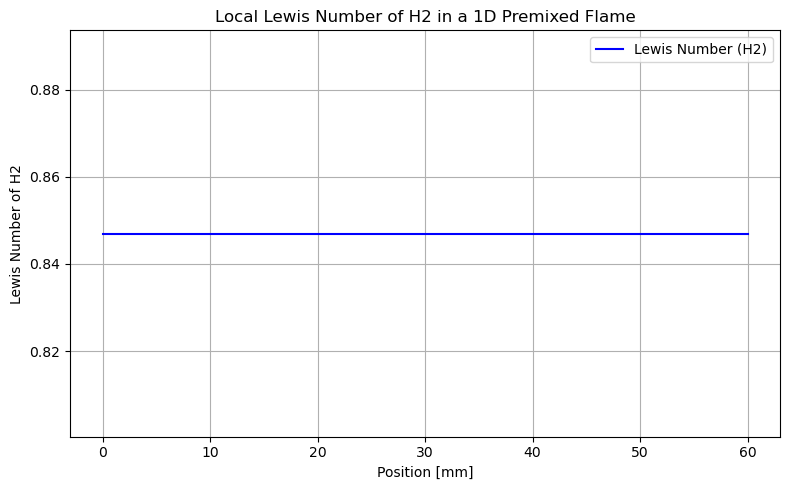

In [ ]:
z = flame.grid
T               = flame.T
T_u, T_b        = T[[0, -1]]
rho_arr         = flame.density
rho_u,  rho_b   = rho_arr[[0, -1]]
eta_u,  eta_b   = flame.viscosity[[0, -1]]
cp_arr          = flame.cp_mass
cp_u,   cp_b    = cp_arr[[0, -1]]
lam_arr         = flame.thermal_conductivity
lam_u,  lam_b   = lam_arr[[0, -1]]


D_H2 = flame.mix_diff_coeffs[gas.species_index('H2')]
D_O2 = flame.mix_diff_coeffs[gas.species_index('O2')]

T_a = 13272.60
E_a = 29.5 * 4185 # J/mol
R_bar = ct.gas_constant / 1000  # [J/mol/K]
print(R_bar)
# Calculation of weighting factor
#Zeld_num  = (E_a / (R_bar T_b**2)) * (T_b - T_u) 
Zeld_num  = (T_a / (T_b**2)) * (T_b - T_u) 

if phi < 1:
    alpha = 1 + Zeld_num * (1 / phi - 1)
else:
    alpha = 1 + Zeld_num * (phi - 1)


# Compute Lewis number of fuel and oxidizer across the flame
Le_H2 = lam_arr / (rho_arr * cp_arr * D_H2)
Le_O2 = lam_arr / (rho_arr * cp_arr * D_O2)
Le_H2 = np.full(len(Le_H2),0.33)
Le_O2 = np.full(len(Le_O2),2.3)

# Compute effective Lewis number
if phi < 1:
    Le_eff = (Le_O2 + alpha * Le_H2) / (1 + alpha)
else:
    Le_eff = (alpha * Le_O2 + Le_H2) / (1 + alpha)

omega = rho_u / rho_b
Pr_u = eta_u * rho_u * cp_u / lam_u
print("\nomega[]   Pr_u[]       Le_eff[]      Beta[]")
print("%.1f       %.6f     %.6f      %.2f" % (omega, Pr_u, Le_eff[0], Zeld_num))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(z * 1000, Le_eff, label='Lewis Number (H2)', color='blue')
plt.xlabel('Position [mm]')
plt.ylabel('Lewis Number of H2')
plt.title('Local Lewis Number of H2 in a 1D Premixed Flame')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

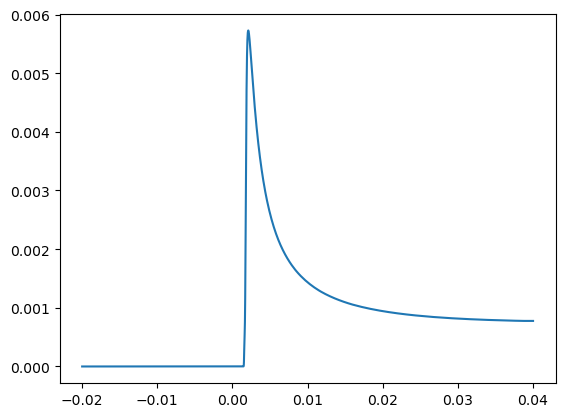

TEMP  -2.00000e+00 2.98000e+02
TEMP  1.15000e-01 2.98043e+02
TEMP  1.30469e-01 2.99099e+02
TEMP  1.35859e-01 3.01820e+02
TEMP  1.39961e-01 3.08077e+02
TEMP  1.42305e-01 3.15600e+02
TEMP  1.44648e-01 3.28652e+02
TEMP  1.46230e-01 3.42335e+02
TEMP  1.47402e-01 3.56006e+02
TEMP  1.48574e-01 3.73452e+02
TEMP  1.49570e-01 3.91768e+02
TEMP  1.50156e-01 4.04206e+02
TEMP  1.50742e-01 4.17950e+02
TEMP  1.51387e-01 4.34614e+02
TEMP  1.52500e-01 4.67186e+02
TEMP  1.53086e-01 4.86168e+02
TEMP  1.53672e-01 5.06310e+02
TEMP  1.54375e-01 5.31840e+02
TEMP  1.55488e-01 5.74733e+02
TEMP  1.56719e-01 6.24585e+02
TEMP  1.57891e-01 6.73322e+02
TEMP  1.59062e-01 7.22358e+02
TEMP  1.60234e-01 7.71005e+02
TEMP  1.61406e-01 8.18778e+02
TEMP  1.62578e-01 8.65350e+02
TEMP  1.63750e-01 9.10509e+02
TEMP  1.64922e-01 9.54117e+02
TEMP  1.66152e-01 9.98139e+02
TEMP  1.67324e-01 1.03831e+03
TEMP  1.69141e-01 1.09710e+03
TEMP  1.71484e-01 1.16654e+03
TEMP  1.73828e-01 1.22868e+03
TEMP  1.76172e-01 1.28365e+03
TEMP  1.7

In [ ]:
#plt.plot(flame.flame.grid,flame.Y[0,:]); plt.show()
plt.plot(flame.grid-0.02,flame.Y[5]); plt.show()
for i in range(np.shape(flame.T)[0]):
    if (i%20==0): 
        #print("%.5e %.5e %.5e %.5e %.5e %.5e %.5e %.5e %.5e %.5e %.5e" % (100*.flame.grid[i], flame.T[i], flame.Y[0,i], flame.Y[1,i], flame.Y[2,i], flame.Y[3,i], flame.Y[4,i], flame.Y[5,i], flame.Y[6,i], flame.Y[7,i], flame.Y[8,i]) )
        print("TEMP  %.5e %.5e" % (100*flame.grid[i]- 2, flame.T[i]))  # shifted profile

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Florian\AppData\Local\Temp\ipykernel_26456\2261654076.py:10: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("$\delta_f$  [cm]" )


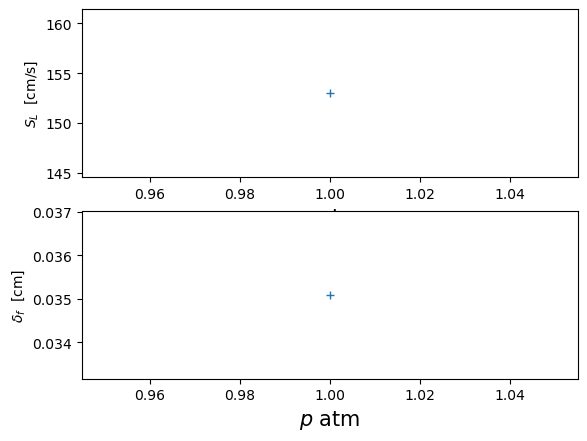


mixture:  H2:1.0, H2O:0.0, N2:0.0
equivalence ratio =  0.75  Tu =  298.0 K

p[atm]     SL[cm/s]    deltaf[cm]       Nelm      t[s]


In [ ]:
# Plot results
plt.subplot(2,1,1)
plt.plot(pres, SL,'+-')
plt.xlabel(r'$p$ atm', fontsize=15)
plt.ylabel("$S_L$  [cm/s]" )

plt.subplot(2,1,2)
plt.plot(pres, deltaf,'+-')
plt.xlabel(r'$p$ atm', fontsize=15)
plt.ylabel("$\delta_f$  [cm]" )
plt.show()

print('\nmixture: ', mixture)
print('equivalence ratio = ', phi, ' Tu = ', Tu, 'K' )
print("\np[atm]     SL[cm/s]    deltaf[cm]       Nelm      t[s]")
#D = 7.5  # [cm]
#H = 3.0  # [cm]
#V = np.pi * D**2/4 * H
#for i in range(len(pres_list)):
#     print("%.3f   %.6e   %.6e  %9d  %.3e" % (pres[i], SL[i], deltaf[i], V/deltaf[i]**3, 0.5*H/SL[i]))

In [ ]:
print('\nequivalence ratio = ', phi, ' Tu = ', Tu, ' K' )
print("\np[atm]     SL[cm/s]    deltaf[cm]       Nelm")
D = 7.5  # [cm]
H = 3.0  # [cm]
V = np.pi * D**2/4 * H
for i in range(len(pres_list)):
     print("%.3f   %.6e   %.6e  %9d" % (pres[i], SL[i], deltaf[i], V/deltaf[i]**3 ))


equivalence ratio =  2.0  Tu =  298.0  K

p[atm]     SL[cm/s]    deltaf[cm]       Nelm
1.000   2.956482e+02   3.359046e-02    3496921


In [1]:
phi = 0.15
gas=ct.Solution('Chemical mechanisms/BurkeH2.yaml')
gas.set_equivalence_ratio(phi, 'H2:1.0', 'O2:0.21, N2:0.79')
gas.TP = T0, pres_list[0]
print ("Unburned mixture fractions ", gas.Y)
print ("Unburned mixture concentrations ", gas.R) 
gas.equilibrate('HP')
print("Product mixture fractions", flame.Y[:,-1])
print(gas.species_names)

NameError: name 'ct' is not defined

In [ ]:
gas.transport_model="multicomponent"
flame.soret_enabled='True'

In [ ]:
gas.Y=flame.Y[:,0]

In [ ]:
gas.TP=flame.T[0], PP

In [ ]:
np.sum(flame.Y[:,npts-1])

np.float64(1.0)

In [ ]:
gas.Y

array([1.73043249e-02, 2.28878881e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.75142967e-17, 0.00000000e+00,
       7.53816794e-01])

In [ ]:
gas.thermal_diff_coeffs

array([-4.33213998e-07,  1.66414626e-07, -4.23325808e-23,  3.65025475e-23,
       -1.69578112e-22, -8.96761412e-23,  2.06415903e-22,  1.43964788e-22,
        2.66799372e-07])

In [ ]:
gas.multi_diff_coeffs

array([[0.00000000e+00, 2.31862636e-04, 3.02169898e-04, 1.50814660e-03,
        4.29675445e-04, 4.21993210e-04, 2.76902499e-04, 2.75108656e-04,
        1.24209751e-04],
       [7.07074681e-05, 0.00000000e+00, 1.90378935e-05, 9.50191745e-05,
        2.70712450e-05, 2.65872340e-05, 1.74459478e-05, 1.73329287e-05,
        1.94230768e-05],
       [1.21196357e-04, 2.84619574e-05, 0.00000000e+00, 1.68771776e-04,
        4.80835802e-05, 4.72238863e-05, 3.09872572e-05, 3.07865141e-05,
        2.40508627e-05],
       [1.91572727e-03, 4.58137840e-04, 6.04339797e-04, 0.00000000e+00,
        8.59350890e-04, 8.43986421e-04, 5.53804998e-04, 5.50217313e-04,
        2.25470406e-04],
       [1.37096075e-04, 3.34094687e-05, 3.80757869e-05, 1.90038349e-04,
        0.00000000e+00, 5.31744679e-05, 3.48918956e-05, 3.46658573e-05,
        3.19173445e-05],
       [1.29519709e-04, 3.16775949e-05, 3.58190460e-05, 1.78774831e-04,
        5.09334801e-05, 0.00000000e+00, 3.28238630e-05, 3.26112219e-05,
        3.0

In [ ]:
gas.TP=flame.T[npts-1], PP
gas.Y=flame.Y[:,npts-1]
gas.transport_model="multicomponent"
gas.thermal_diff_coeffs

array([-1.82707079e-10,  3.73200020e-07, -1.55763561e-06, -6.30227772e-12,
       -2.17694958e-10, -6.97476979e-09,  9.67510196e-12,  9.97610159e-13,
        1.19180639e-06])

In [ ]:
gas.transport_model='mixture-averaged'
gas.mix_diff_coeffs

array([3.38276083e-04, 9.42454646e-05, 1.29152835e-04, 5.67893738e-04,
       1.46532484e-04, 1.43820218e-04, 9.49373177e-05, 9.43121463e-05,
       9.05537855e-05])

In [ ]:
gas.TP=T0, 5*ct.one_atm
gas.set_equivalence_ratio(0.60, 'H2:1.0', 'O2:0.21, N2:0.79')

In [ ]:
gas.equilibrate('HP')
gas()


  gas:

       temperature   1789.5 K
          pressure   1 Pa
           density   1.6683e-06 kg/m^3
  mean mol. weight   24.822 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy           -136.02           -3376.2  J
   internal energy       -5.9956e+05       -1.4882e+07  J
           entropy             14204        3.5256e+05  J/K
    Gibbs function       -2.5418e+07       -6.3091e+08  J
 heat capacity c_p            1554.6             38589  J/K
 heat capacity c_v            1219.7             30274  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2         0.0013374          0.016467            -34.75
                O2          0.062375          0.048386           -42.919
               H2O           0.17051           0.23494            -56.21
    